# 🌌 Photo-Z Challenge: Training Pipeline

Welcome to the Photo-Z Challenge! 🚀 This notebook provides a step-by-step guide to run the machine learning pipeline to predict redshift. 

We will learn from a baseline dataset representing nominal observational conditions. The training set is composed of 300,000 galaxies and 20,000 QSOs (Quasars).

Let's start by setting up our environment and thread limits to ensure reproducible and efficient computation. 🛠️

In [14]:
# --- 2. LIBRARIES ---
import os
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import joblib
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestRegressor

## ⚙️ Step 1: Configuration Definition

Instead of loading an external file, we define our entire experiment configuration right here! 📝 This dictionary holds our feature selections, model hyperparameters, and training settings. 

For instance, our Artificial Neural Network (ANN) uses two hidden layers of 64 neurons each and dropout rates of 0.1.

In [19]:
# Experiment and model configuration embedded directly in the notebook
cfg = {
    "experiment": {
        "group_name": "ASTOSMART",
        "save_dir": "models/"
    },
    "data": {
        "train_path": "data/training_set.h5", # Adjusted path assuming notebook is in photoz_challenge/
        "val_path": "data/validation_set.h5",
        "batch_size": 1000,
        "target_col": "Z",
        "inputs": {
            "FilterJPAS": [
                'J0378', 'J0390', 'J0400', 'J0410', 'J0420', 'J0430', 'J0440', 'J0450',
                'J0460', 'J0470', 'J0480', 'J0490', 'J0500', 'J0510', 'J0520', 'J0530',
                'J0540', 'J0550', 'J0560', 'J0570', 'J0580', 'J0590', 'J0600', 'J0610',
                'J0620', 'J0630', 'J0640', 'J0650', 'J0660', 'J0670', 'J0680', 'J0690',
                'J0700', 'J0710', 'J0720', 'J0730', 'J0740', 'J0750', 'J0760', 'J0770',
                'J0780', 'J0790', 'J0800', 'J0810', 'J0820', 'J0830', 'J0840', 'J0850',
                'J0860', 'J0870', 'J0880', 'J0890', 'J0900', 'J0910'
            ],
            "MAGNITUDES": [
                'MAG_NUV','MAG_FUV','MAG_G','MAG_R','MAG_i','MAG_Z',"MAG_J_2MASS",
                "MAG_H_2MASS","MAG_Ks_2MASS",'MAG_W1','MAG_W2','MAG_W3','MAG_W4', 'iSDSS'
            ]
        },
        "selected_features": ["FilterJPAS", "MAGNITUDES"],
        "features_to_normalize": ["MAGNITUDES"]
    },
    "model": {
        "type": "neural_net", # Options: "neural_net", "random_forest"
        "hidden_layers": [64, 64],
        "dropout_rates": [0.1, 0.1],
        "output_size": 1,
        "n_estimators": 500,
        "max_depth": 100
    },
    "training": {
        "epochs": 10,
        "learning_rate": 0.001,
        "loss_type": "deltaz"
    }
}

## 🧠 Step 2: Model Architectures

Here we define our machine learning algorithms. By default, this pipeline includes two models: an Artificial Neural Network (ANN) and a Random Forest (RF). 

We also define a custom `DeltaZLoss` function to optimize for the standard Photo-Z metric: the absolute difference between predicted and true redshift divided by 1 plus the true redshift.

In [20]:
class PhotoZNet(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rates):
        super(PhotoZNet, self).__init__()
        
        layers = []
        in_dim = input_size
        
        # Dynamic construction of hidden layers
        for h_dim, drop_rate in zip(hidden_layers, dropout_rates):
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(drop_rate))
            in_dim = h_dim
            
        # Linear output layer
        layers.append(nn.Linear(in_dim, 1))
        
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

class DeltaZLoss(nn.Module):
    def __init__(self):
        super(DeltaZLoss, self).__init__()
        
    def forward(self, y_pred, y_true):
        # Standard Photo-Z metric: |dz| / (1+z)
        numerator = torch.abs(y_pred - y_true)
        denominator = 1.0 + y_true
        return torch.mean(numerator / denominator)

class RandomForestPhotoZ:
    def __init__(self, n_estimators=100, max_depth=None):
        self.model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            n_jobs=-1,
            random_state=42
        )

    def fit(self, X, y):
        self.model.fit(X, y.ravel())

    def predict(self, X):
        # Calculate predictions from all individual trees to estimate uncertainty
        preds = np.array([tree.predict(X) for tree in self.model.estimators_])
        mean_pred = np.mean(preds, axis=0)
        std_pred = np.std(preds, axis=0) 
        return mean_pred, std_pred

    def save(self, path):
        joblib.dump(self.model, path)

## 🗂️ Step 3: Data Processing

Data is the fuel for our models! ⛽ Here we define our Dataset class and the `preprocess_data` function. 

This function handles missing values by replacing NaNs with `0.0` and applies normalization using the Median Absolute Deviation (MAD). Crucially, we only compute the median and MAD on the training set to prevent data leakage into our validation set.

In [21]:
class PhotoZDataset(Dataset):
    def __init__(self, features, targets, types):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets).reshape(-1, 1)
        self.types = np.array(types)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx], self.types[idx]

def get_mad(series):
    median = series.median()
    return (series - median).abs().median()

def preprocess_data(df, config, train_stats=None):
    selected_cols = []
    for group in config['data']['selected_features']:
        selected_cols.extend(config['data']['inputs'][group])
    
    X = df[selected_cols].copy()
    y = df['Z'].values
    types = df['TYPE'].values

    # Replace NaN values with 0.0
    X = X.fillna(0.0)

    # Identify columns that need normalization
    cols_to_norm = []
    for group in config['data']['features_to_normalize']:
        if group in config['data']['selected_features']:
             cols_to_norm.extend(config['data']['inputs'][group])
    
    # Compute median and MAD only for the training set to prevent data leakage
    if train_stats is None:
        medians = X[cols_to_norm].median()
        mads = X[cols_to_norm].apply(get_mad)
        # Prevent division by zero
        mads = mads.replace(0, 1.0)
        train_stats = {'medians': medians, 'mads': mads}
    
    # Apply normalization using the training statistics
    X[cols_to_norm] = (X[cols_to_norm] - train_stats['medians']) / train_stats['mads']
    
    return X.values, y, types, train_stats, len(selected_cols)

## 🏋️‍♂️ Step 4: Training Pipeline Execution

Time to train! 🔥 The `run_training` function orchestrates the whole process:
1. Loads the `.h5` files into Pandas DataFrames.
2. Preprocesses the data.
3. Initializes the chosen model (Neural Network or Random Forest) based on `config.yaml`.
4. Trains the model and evaluates it dynamically on validation GALAXY and QSO types.

In [22]:
def run_training(cfg):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Usando dispositivo: {device}")

    print("Cargando datos...")
    df_train = pd.read_hdf(cfg['data']['train_path'], key='data')
    df_val = pd.read_hdf(cfg['data']['val_path'], key='data')

    print("Preprocesando datos...")
    X_train, y_train, types_train, stats, input_dim = preprocess_data(df_train, cfg, train_stats=None)
    X_val, y_val, types_val, _, _ = preprocess_data(df_val, cfg, train_stats=stats)

    model_type = cfg['model'].get('type', 'neural_net')
    os.makedirs(cfg['experiment']['save_dir'], exist_ok=True)

    if model_type == 'neural_net':
        train_dataset = PhotoZDataset(X_train, y_train, types_train)
        val_dataset = PhotoZDataset(X_val, y_val, types_val)
        
        train_loader = DataLoader(train_dataset, batch_size=cfg['data']['batch_size'], shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=cfg['data']['batch_size'], shuffle=False)
        
        print(f"Inicializando modelo '{cfg['experiment']['group_name']}'...")
        model = PhotoZNet(
            input_size=input_dim,
            hidden_layers=cfg['model']['hidden_layers'],
            dropout_rates=cfg['model']['dropout_rates']
        ).to(device)

        criterion = DeltaZLoss() if cfg['training']['loss_type'] == 'deltaz' else nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=cfg['training']['learning_rate'])

        epochs = cfg['training']['epochs']
        print(f"Comenzando entrenamiento por {epochs} épocas.")

        for epoch in range(epochs):
            model.train()
            train_loss_acc = 0.0
            
            pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
            for inputs, targets, _ in pbar:
                inputs, targets = inputs.to(device), targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                train_loss_acc += loss.item()
                pbar.set_postfix({'loss': f"{loss.item():.4f}"})
            
            avg_train_loss = train_loss_acc / len(train_loader)

            model.eval()
            val_loss_acc = 0.0
            all_val_outputs, all_val_targets, all_val_types = [], [], []
            
            with torch.no_grad():
                for v_inputs, v_targets, v_types in val_loader:
                    v_inputs, v_targets = v_inputs.to(device), v_targets.to(device)
                    v_outputs = model(v_inputs)
                    v_loss = criterion(v_outputs, v_targets)
                    
                    val_loss_acc += v_loss.item()
                    all_val_outputs.append(v_outputs.cpu())
                    all_val_targets.append(v_targets.cpu())
                    all_val_types.extend(v_types)
                
                total_val_loss = val_loss_acc / len(val_loader)
                val_outputs_cat = torch.cat(all_val_outputs)
                val_targets_cat = torch.cat(all_val_targets)
                val_types_np = np.array(all_val_types)
                
                unique_types = np.unique(val_types_np)
                type_metrics = {}
                for t in unique_types:
                    mask = (val_types_np == t)
                    if np.sum(mask) > 0:
                        type_metrics[t] = criterion(val_outputs_cat[mask], val_targets_cat[mask]).item()

            msg = f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f} | Val Loss Global: {total_val_loss:.4f}"
            for t, l in type_metrics.items(): msg += f" | {t}: {l:.4f}"
            print(msg)

        save_path = os.path.join(cfg['experiment']['save_dir'], f"{cfg['experiment']['group_name']}.pth")
        torch.save(model.state_dict(), save_path)
        print(f"\nModelo guardado en: {save_path}")

    elif model_type == 'random_forest':
        # Sample 10% for speed as per the script
        n_sample = max(1, int(0.1 * X_train.shape[0]))
        sample_indices = np.random.choice(X_train.shape[0], size=n_sample, replace=False)
        X_train, y_train, types_train = X_train[sample_indices], y_train[sample_indices], types_train[sample_indices]

        print(f"Inicializando modelo Random Forest '{cfg['experiment']['group_name']}'...")
        rf_model = RandomForestPhotoZ(n_estimators=cfg['model'].get('n_estimators', 100), max_depth=cfg['model'].get('max_depth', None))
        
        print("Entrenando Random Forest...")
        rf_model.fit(X_train, y_train)
        
        print("Evaluando Random Forest en validacion...")
        mean_pred, std_pred = rf_model.predict(X_val)
        
        y_val_flat = y_val.ravel()
        numerator = np.abs(mean_pred - y_val_flat)
        denominator = 1.0 + y_val_flat
        total_val_loss = np.mean(numerator / denominator)
        
        unique_types = np.unique(types_val)
        type_metrics = {}
        for t in unique_types:
            mask = (types_val == t)
            if np.sum(mask) > 0:
                type_metrics[t] = np.mean(np.abs(mean_pred[mask] - y_val_flat[mask]) / (1.0 + y_val_flat[mask]))
        
        msg = f"Val Loss Global: {total_val_loss:.4f}"
        for t, l in type_metrics.items(): msg += f" | {t}: {l:.4f}"
        print(msg)
        
        save_path = os.path.join(cfg['experiment']['save_dir'], f"{cfg['experiment']['group_name']}_rf.joblib")
        rf_model.save(save_path)
        print(f"\nModelo guardado en: {save_path}")

# --- EJECUCIÓN ---
# Descomenta la siguiente línea para iniciar el entrenamiento
run_training(cfg)

Usando dispositivo: cpu
Cargando datos...
Preprocesando datos...
Inicializando modelo 'ANN_turtle'...
Comenzando entrenamiento por 10 épocas.


Epoch 1/10 [Train]:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.1062 | Val Loss Global: 0.1009 | GALAXY: 0.0568 | QSO: 0.3653


Epoch 2/10 [Train]:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.0801 | Val Loss Global: 0.0942 | GALAXY: 0.0530 | QSO: 0.3414


Epoch 3/10 [Train]:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.0749 | Val Loss Global: 0.0889 | GALAXY: 0.0502 | QSO: 0.3211


Epoch 4/10 [Train]:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.0715 | Val Loss Global: 0.0859 | GALAXY: 0.0488 | QSO: 0.3087


Epoch 5/10 [Train]:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.0688 | Val Loss Global: 0.0844 | GALAXY: 0.0455 | QSO: 0.3178


Epoch 6/10 [Train]:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.0671 | Val Loss Global: 0.0818 | GALAXY: 0.0448 | QSO: 0.3038


Epoch 7/10 [Train]:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.0655 | Val Loss Global: 0.0798 | GALAXY: 0.0437 | QSO: 0.2964


Epoch 8/10 [Train]:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.0643 | Val Loss Global: 0.0802 | GALAXY: 0.0429 | QSO: 0.3039


Epoch 9/10 [Train]:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.0633 | Val Loss Global: 0.0770 | GALAXY: 0.0424 | QSO: 0.2845


Epoch 10/10 [Train]:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.0625 | Val Loss Global: 0.0767 | GALAXY: 0.0418 | QSO: 0.2858

Modelo guardado en: models/ANN_turtle.pth


## 📉 Step 5: Learning Curves Visualization

To truly understand how our Neural Network is learning, we need to look at the **Loss vs. Epoch** plot! 👁️‍🗨️ 

This plot will help us diagnose if our model is **underfitting** (high loss on both train and validation), **overfitting** (train loss goes down, but validation loss goes up), or training perfectly! We break down the validation loss into the global metric, and the specific metrics for **Galaxies** 🌌 and **QSOs** ✨ to see if the model struggles with a particular type of object.

/var/folders/6r/hl4s187n5b37619mh7d94nb40000gn/T/ipykernel_81038/2987987161.py:57: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  plt.tight_layout()
/Users/ginesmartinezsolaeche/miniconda3/envs/photoz_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


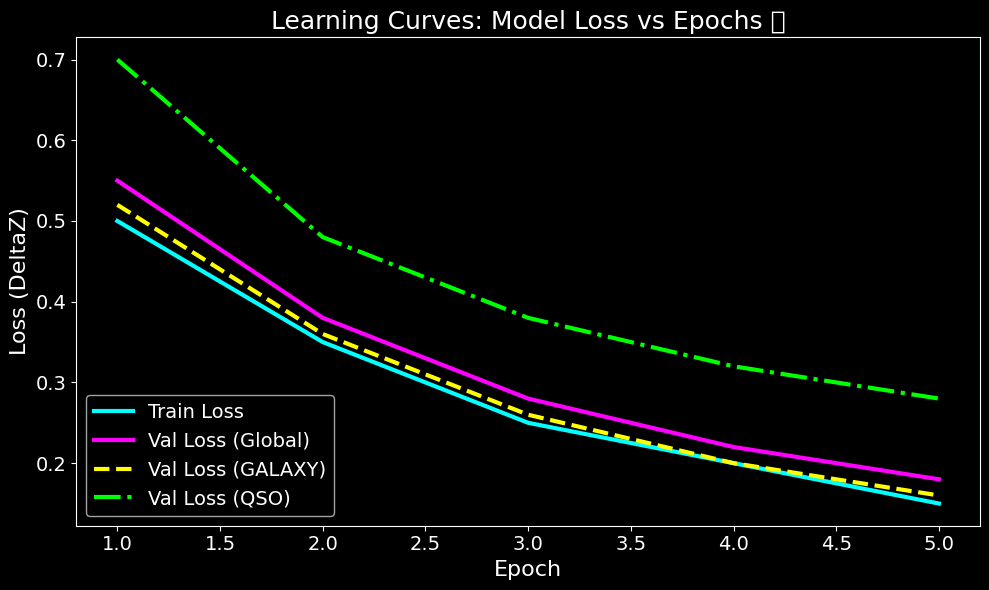

In [23]:
import os

# --- 1. CONFIGURACIÓN DE ENTORNO ---
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt

# Aplicamos el estilo de fondo oscuro para las gráficas 🌌
plt.style.use('dark_background')

def plot_learning_curves(history):
    """
    Plots the training and validation loss over epochs.
    
    Expected 'history' dictionary format:
    {
        'train': [loss_ep1, loss_ep2, ...],
        'val_global': [loss_ep1, loss_ep2, ...],
        'val_GALAXY': [loss_ep1, loss_ep2, ...],
        'val_QSO': [loss_ep1, loss_ep2, ...]
    }
    """
    # Determinamos el número de épocas basadas en la longitud de la lista de train
    epochs = range(1, len(history['train']) + 1)
    
    plt.figure(figsize=(10, 6))
    
    # Dibujamos las líneas más anchas (linewidth=3)
    plt.plot(epochs, history['train'], label='Train Loss', linewidth=3, color='cyan')
    plt.plot(epochs, history['val_global'], label='Val Loss (Global)', linewidth=3, color='magenta')
    
    if 'val_GALAXY' in history and len(history['val_GALAXY']) > 0:
        plt.plot(epochs, history['val_GALAXY'], label='Val Loss (GALAXY)', linewidth=3, linestyle='--', color='yellow')
        
    if 'val_QSO' in history and len(history['val_QSO']) > 0:
        plt.plot(epochs, history['val_QSO'], label='Val Loss (QSO)', linewidth=3, linestyle='-.', color='lime')
        
    # Hacemos las etiquetas (labels) de los ejes más grandes
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss (DeltaZ)', fontsize=16)
    
    # Hacemos los números (ticks) de los ejes más grandes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Nos aseguramos de eliminar la cuadrícula (grid)
    plt.grid(False)
    
    # Leyenda más grande y ubicada abajo a la izquierda (bottom left)
    plt.legend(loc='lower left', fontsize=14)
    
    plt.title('Learning Curves: Model Loss vs Epochs 🚀', fontsize=18)
    plt.tight_layout()
    plt.show()

# --- EJEMPLO DE USO (Mock data) ---
# Si modificaste tu bucle de entrenamiento para guardar el historial, puedes llamarlo así:
# plot_learning_curves(history)

# Aquí creamos unos datos falsos (dummy data) solo para que puedas probar cómo se ve la celda:
dummy_history = {
    'train': [0.50, 0.35, 0.25, 0.20, 0.15],
    'val_global': [0.55, 0.38, 0.28, 0.22, 0.18],
    'val_GALAXY': [0.52, 0.36, 0.26, 0.20, 0.16],
    'val_QSO': [0.70, 0.48, 0.38, 0.32, 0.28]
}
plot_learning_curves(dummy_history)